In [90]:
import pickle as pkl
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 检查是否有可用的GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [98]:
dir = r'D:/R/PycharmProjects/interest/Tox2024/Tox_3/data/'
ahr = dir + 'AUG/ahr_35x_aug.csv'
struc_file = dir + 'ahr_MODELS/ahr_model.pdf'
model_file = dir + 'ahr_MODELS/ahr_model.h5'
pic_file = dir + 'ahr_MODELS/ahr_test.pdf'
ROC_file = dir + 'ahr_MODELS/ahr_ROC.pdf'
Label_file = dir + 'ahr_MODELS/ahr_label.pkl'

In [99]:
data = pd.read_csv(ahr)
smiles_data = data['SMILES']
activity_data = data['ACTIVITY']
pos = len(data[data['ACTIVITY'] == 1])
neg = len(data[data['ACTIVITY'] == 0])
print(f"Positive: {pos}, Negative: {neg}, Ratio: {neg/pos}")
data.head()

Positive: 27293, Negative: 32238, Ratio: 1.1811819880555454


,SMILES,ACTIVITY
0,Cl.c12ccccc1c([C@@H](C)NCCCc1cccc(C(F)(F)F)c1)...,0
1,N([C@@H](c1c2c(ccc1)cccc2)C)CCCc1cc(C(F)(F)F)c...,0
2,c1cc([C@@H](C)NCCCc2cc(C(F)(F)F)ccc2)c2c(cccc2...,0
3,Cl.C[C@@H](NCCCC1=CC=CC(=C1)C(F)(F)F)C2=CC=CC3...,0
4,c1c([C@H](NCCCc2cc(C(F)(F)F)ccc2)C)c2ccccc2cc1.Cl,0


In [100]:
# 数据预处理
max_length = 128
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(smiles_data)
smiles_data = tokenizer.texts_to_sequences(smiles_data)
smiles_data = pad_sequences(smiles_data, maxlen=max_length, padding='post', truncating='post')
activity_data = np.array(activity_data)
with open(Label_file, 'wb') as handle:
    pkl.dump(tokenizer, handle)

# 打印字符到整数的映射
print("Character to integer mapping:")
print(tokenizer.word_index)

# 定义模型参数
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128  # 256
lstm_units = 512

# 将整数序列转换为one-hot编码
x_onehot = np.eye(vocab_size)[smiles_data]

# 假设 X 是你的特征数据，y 是你的标签数据
x_train, x_test, y_train, y_test = train_test_split(x_onehot, activity_data, test_size=0.1, random_state=42)

# 构建模型
model = Sequential([
    Input(shape=(max_length, vocab_size)),
    # LSTM(lstm_units, return_sequences=True),
    LSTM(lstm_units),
    Dense(1, activation='sigmoid')
])

# 编译模型
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

plot_model(model, to_file=struc_file, show_shapes=True, show_layer_names=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# 打印模型概要
model.summary()

# 训练模型
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Character to integer mapping:
{'c': 1, '(': 2, ')': 3, 'o': 4, '1': 5, '=': 6, 'n': 7, '2': 8, '[': 9, ']': 10, '@': 11, 'h': 12, '3': 13, 'l': 14, 's': 15, '-': 16, '.': 17, 'f': 18, '+': 19, '4': 20, '/': 21, 'b': 22, 'r': 23, 'a': 24, 'p': 25, '\\': 26, 'i': 27, '5': 28, '#': 29, '6': 30, '7': 31, 'k': 32, '8': 33, 'e': 34, 'u': 35, 'g': 36, 't': 37, '9': 38, '%': 39, 'z': 40, 'm': 41, '0': 42, 'd': 43, 'v': 44, 'y': 45}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 512)               1144832   
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1145345 (4.37 MB)
Trainable params: 1145345 (4.37 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________

KeyboardInterrupt: 

In [68]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
417/417 [==============================] - 150s 360ms/step - loss: 0.3004 - accuracy: 0.8737 - val_loss: 0.3445 - val_accuracy: 0.8540
Epoch 2/10
417/417 [==============================] - 149s 358ms/step - loss: 0.2827 - accuracy: 0.8825 - val_loss: 0.3149 - val_accuracy: 0.8673
Epoch 3/10
417/417 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8813

KeyboardInterrupt: 

In [67]:
model.save(model_file)

d:\Program Files\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
# 评估模型
y_pred = model.predict([x_test])
thread = 0.5
y_max = np.where(y_pred > thread, 1, y_pred)
y_max = np.where(y_max < thread, 0, y_max)
print(classification_report(y_test, y_max))
print(confusion_matrix(y_test, y_max))

206/206 [==============================] - 11s 52ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3552
           1       0.86      0.85      0.85      3030

    accuracy                           0.87      6582
   macro avg       0.87      0.87      0.87      6582
weighted avg       0.87      0.87      0.87      6582

[[3147  405]
 [ 467 2563]]


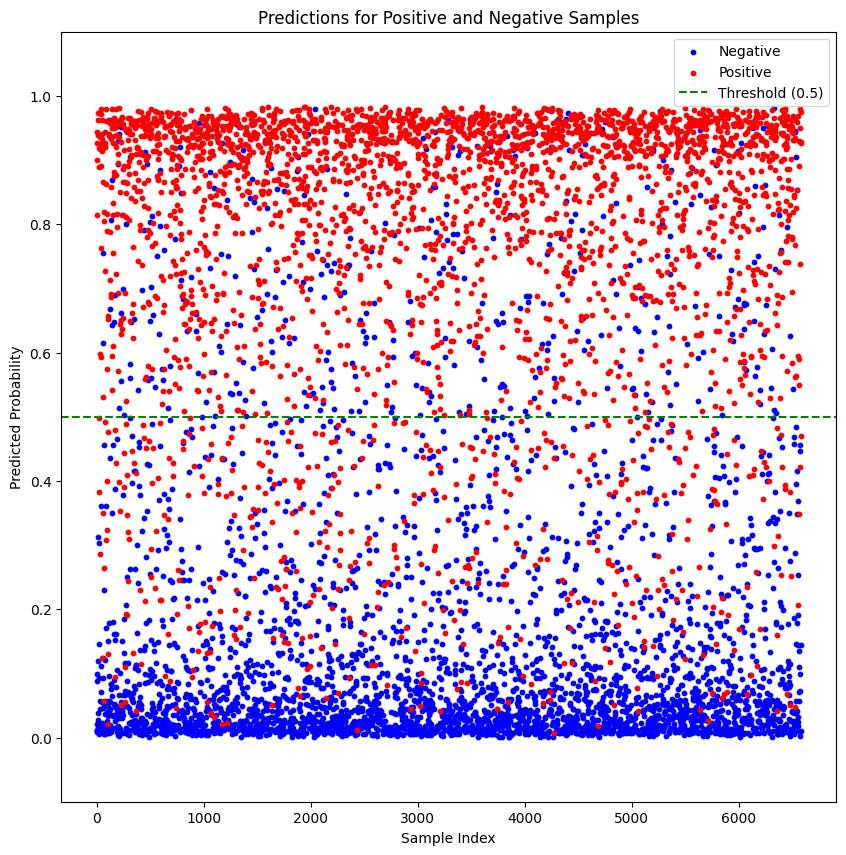

In [65]:
# 创建图形
plt.figure(figsize=(10, 10))

# 绘制阴性样本（标签为 0）
plt.scatter(np.arange(len(y_test))[y_test == 0], y_pred[y_test == 0], 
            color='blue', label='Negative', alpha=1, s=10)

# 绘制阳性样本（标签为 1）
plt.scatter(np.arange(len(y_test))[y_test == 1], y_pred[y_test == 1], 
            color='red', label='Positive', alpha=1, s=10)

# 添加一条阈值线（默认为 0.5）
plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

# 设置图表标题和轴标签
plt.title('Predictions for Positive and Negative Samples')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')

# 添加图例
plt.legend()

# 调整y轴的范围
plt.ylim(-0.1, 1.1)

# 显示图形
plt.savefig(pic_file)

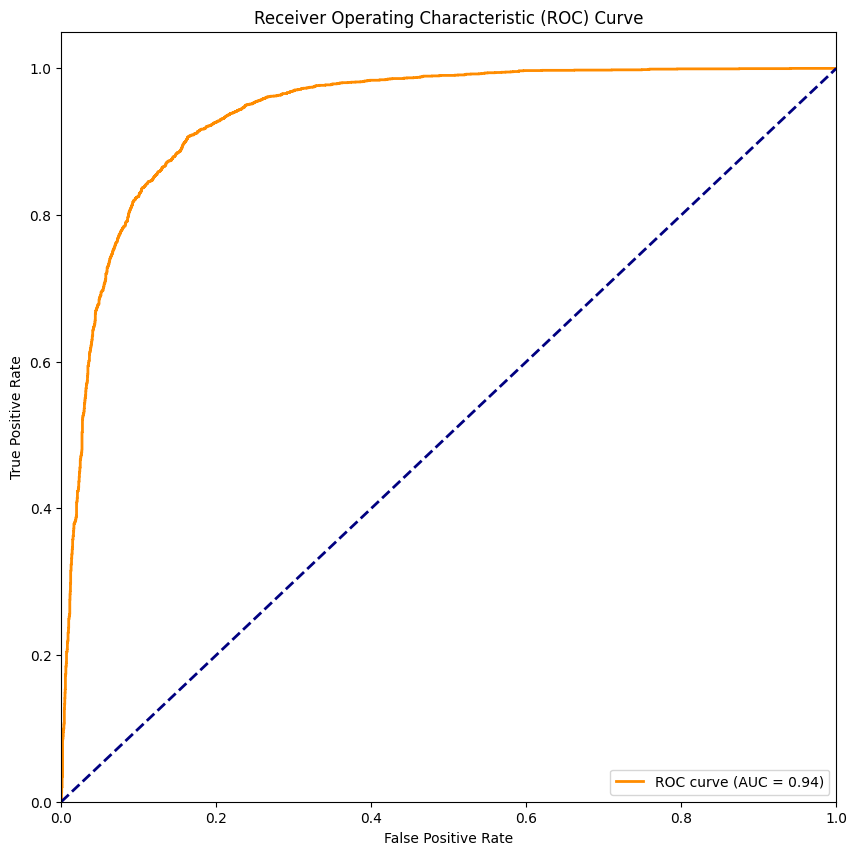

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# 计算 AUC
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(ROC_file)